## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from sklearn.metrics import accuracy_score
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [2]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')

root_path = 'fmnist'
mkdir(root_path)

Directory fmnist already exists!


In [3]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path,
                                                        train=True,
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path,
                                                       train=False,
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

In [4]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [5]:
len(fmnist_dataset_test)

10000

In [6]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [44]:
class TinyNeuralNetwork(nn.Module):

    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(TinyNeuralNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, 256),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

In [45]:
model = TinyNeuralNetwork().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

In [46]:
torchsummary.summary(model, (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 256]         200,960
           Dropout-3                  [-1, 256]               0
              ReLU-4                  [-1, 256]               0
            Linear-5                  [-1, 256]          65,792
              ReLU-6                  [-1, 256]               0
            Linear-7                   [-1, 10]           2,570
Total params: 269,322
Trainable params: 269,322
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.03
Estimated Total Size (MB): 1.05
----------------------------------------------------------------


In [47]:
def train_func(model, train_loader, opt, loss_func):
    epoch_train_loss = []
    epoch_train_accuracy = []

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        predictions = model.forward(images)
        loss = loss_func(predictions, labels)
        loss.backward()

        opt.step()
        opt.zero_grad()

        epoch_train_loss.append(loss.item())
        predictions = predictions.argmax(dim=-1).cpu().numpy()
        epoch_train_accuracy.append(accuracy_score(predictions, labels.cpu().numpy()))
    return (epoch_train_loss, epoch_train_accuracy)

def test_func(model, test_loader, loss_func):
    epoch_test_loss = []
    epoch_test_accuracy = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            predictions = model.forward(images)

            loss = loss_func(predictions, labels)
            epoch_test_loss.append(loss.item())

            preds = predictions.argmax(dim=-1).cpu().numpy()
            epoch_test_accuracy.append(accuracy_score(preds, labels.cpu().numpy()))
    return (epoch_test_loss, epoch_test_accuracy)

def logging(epoch, n_epochs, train_loss, train_accuracy, test_loss, test_accuracy):
    print(
        f"Epoch [{epoch + 1}/{n_epochs}], "
        f"Train Loss: {train_loss[epoch]:.4f}, "
        f"Train Accuracy: {train_accuracy[epoch]:.4f}, "
        f"Test Loss: {test_loss[epoch]:.4f}, "
        f"Test Accuracy: {test_accuracy[epoch]:.4f}"
    )

In [48]:
n_epochs = 20

train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []

In [49]:
for epoch in range(n_epochs):

    model.train()

    epoch_train_loss, epoch_train_accuracy =  train_func(model, train_loader, optimizer, loss_func)
    train_loss.append(sum(epoch_train_loss) / len(epoch_train_loss))
    train_accuracy.append(sum(epoch_train_accuracy) / len(epoch_train_accuracy))

    model.eval()

    epoch_test_loss, epoch_test_accuracy = test_func(model, test_loader, loss_func)
    test_loss.append(sum(epoch_test_loss) / len(epoch_test_loss))
    test_accuracy.append(sum(epoch_test_accuracy) / len(epoch_test_accuracy))

    logging(epoch, n_epochs, train_loss, train_accuracy, test_loss, test_accuracy)

Epoch [1/20], Train Loss: 0.6232, Train Accuracy: 0.7737, Test Loss: 0.4389, Test Accuracy: 0.8422
Epoch [2/20], Train Loss: 0.4420, Train Accuracy: 0.8392, Test Loss: 0.3993, Test Accuracy: 0.8557
Epoch [3/20], Train Loss: 0.4109, Train Accuracy: 0.8500, Test Loss: 0.3967, Test Accuracy: 0.8570
Epoch [4/20], Train Loss: 0.3881, Train Accuracy: 0.8584, Test Loss: 0.3754, Test Accuracy: 0.8592
Epoch [5/20], Train Loss: 0.3757, Train Accuracy: 0.8620, Test Loss: 0.3567, Test Accuracy: 0.8709
Epoch [6/20], Train Loss: 0.3603, Train Accuracy: 0.8672, Test Loss: 0.3635, Test Accuracy: 0.8653
Epoch [7/20], Train Loss: 0.3544, Train Accuracy: 0.8691, Test Loss: 0.3478, Test Accuracy: 0.8738
Epoch [8/20], Train Loss: 0.3426, Train Accuracy: 0.8735, Test Loss: 0.3476, Test Accuracy: 0.8745
Epoch [9/20], Train Loss: 0.3376, Train Accuracy: 0.8747, Test Loss: 0.3342, Test Accuracy: 0.8813
Epoch [10/20], Train Loss: 0.3268, Train Accuracy: 0.8783, Test Loss: 0.3363, Test Accuracy: 0.8815
Epoch [11

In [51]:
print('Train Loss:', train_loss[-1])
print('Test Loss:', test_loss[-1])
print()
print('Train Accuracy:', train_accuracy[-1])
print('Test Accuracy:', test_accuracy[-1])

Train Loss: 0.2830062332247366
Test Loss: 0.31134594660252335

Train Accuracy: 0.8938677149964463
Test Accuracy: 0.88984375


In [52]:
def plot_accuracy(train_loss, test_loss):
    plt.figure(figsize=(10, 6))
    plt.title('Accuracy')
    plt.plot(np.array(train_loss), label='Train Accuracy')
    plt.plot(np.array(test_loss),  label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim(0.75, 1.0)
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_loss(train_loss, test_loss):
    plt.figure(figsize=(10, 6))
    plt.title('Loss')
    plt.plot(np.array(train_loss), label='Train Loss')
    plt.plot(np.array(test_loss), label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.grid(True)
    plt.legend()
    plt.show()

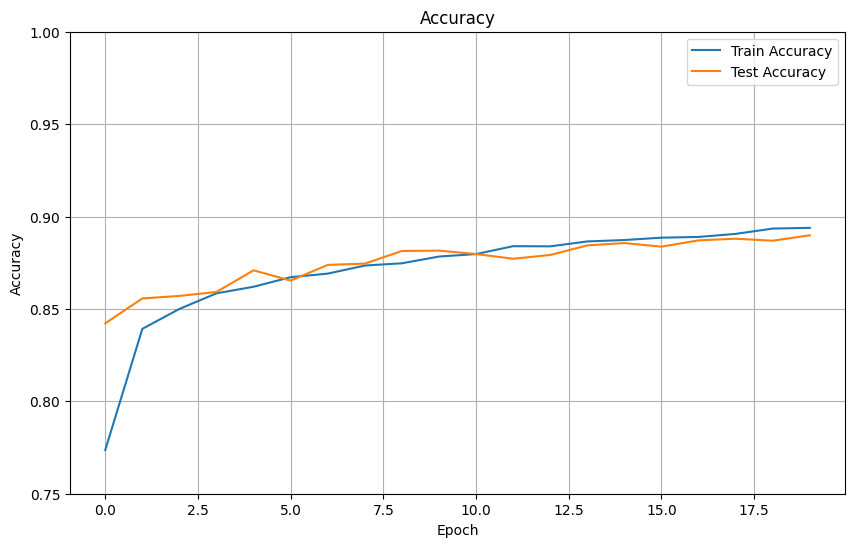

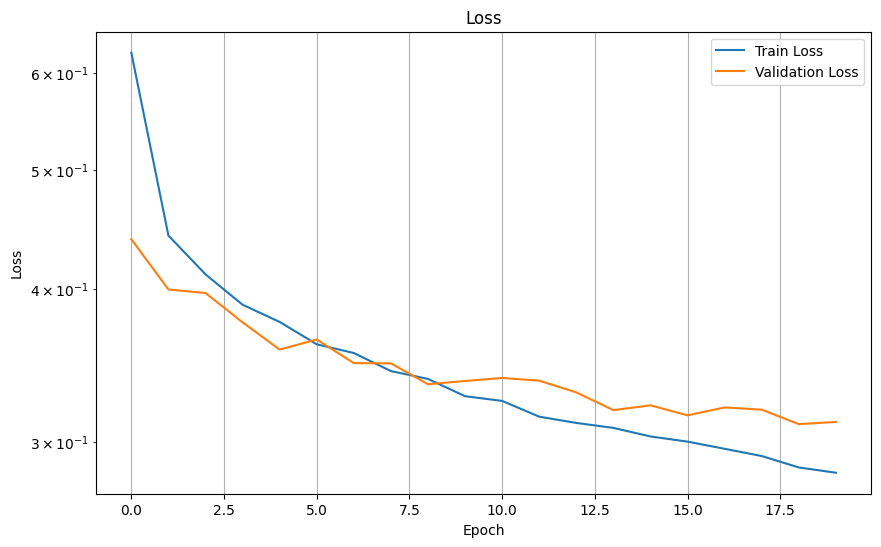

In [53]:
plot_accuracy(train_accuracy, test_accuracy)
plot_loss(train_loss, test_loss)

По условию задачи требовалось получить точность на тестовой выборке $\geq 0.885$, что удалость получить используя только линейный слои и подборая шаг lr. На графиках уже видно начало переобучения, в следующем задании усилим этот эффект его еще больше.

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [64]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(OverfittingNeuralNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, 256),
            nn.Dropout(0.1),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.Dropout(0.1),
            nn.ReLU(),
            nn.Linear(256, num_classes),
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

In [66]:
model = OverfittingNeuralNetwork().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
loss_func = nn.CrossEntropyLoss()

In [67]:
torchsummary.summary(model, (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 256]         200,960
           Dropout-3                  [-1, 256]               0
              ReLU-4                  [-1, 256]               0
            Linear-5                  [-1, 256]          65,792
           Dropout-6                  [-1, 256]               0
              ReLU-7                  [-1, 256]               0
            Linear-8                   [-1, 10]           2,570
Total params: 269,322
Trainable params: 269,322
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.03
Estimated Total Size (MB): 1.05
----------------------------------------------------------------


In [68]:
n_epochs = 50

train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []

In [69]:
for epoch in range(n_epochs):

    model.train()

    epoch_train_loss, epoch_train_accuracy =  train_func(model, train_loader, optimizer, loss_func)
    train_loss.append(sum(epoch_train_loss) / len(epoch_train_loss))
    train_accuracy.append(sum(epoch_train_accuracy) / len(epoch_train_accuracy))

    model.eval()

    epoch_test_loss, epoch_test_accuracy = test_func(model, test_loader, loss_func)
    test_loss.append(sum(epoch_test_loss) / len(epoch_test_loss))
    test_accuracy.append(sum(epoch_test_accuracy) / len(epoch_test_accuracy))

    logging(epoch, n_epochs, train_loss, train_accuracy, test_loss, test_accuracy)

Epoch [1/50], Train Loss: 0.5263, Train Accuracy: 0.8075, Test Loss: 0.4420, Test Accuracy: 0.8433
Epoch [2/50], Train Loss: 0.3815, Train Accuracy: 0.8612, Test Loss: 0.3856, Test Accuracy: 0.8587
Epoch [3/50], Train Loss: 0.3452, Train Accuracy: 0.8736, Test Loss: 0.3745, Test Accuracy: 0.8671
Epoch [4/50], Train Loss: 0.3265, Train Accuracy: 0.8801, Test Loss: 0.3453, Test Accuracy: 0.8757
Epoch [5/50], Train Loss: 0.3095, Train Accuracy: 0.8839, Test Loss: 0.3494, Test Accuracy: 0.8732
Epoch [6/50], Train Loss: 0.2972, Train Accuracy: 0.8900, Test Loss: 0.3729, Test Accuracy: 0.8621
Epoch [7/50], Train Loss: 0.2866, Train Accuracy: 0.8925, Test Loss: 0.3344, Test Accuracy: 0.8796
Epoch [8/50], Train Loss: 0.2783, Train Accuracy: 0.8964, Test Loss: 0.3294, Test Accuracy: 0.8797
Epoch [9/50], Train Loss: 0.2728, Train Accuracy: 0.8984, Test Loss: 0.3241, Test Accuracy: 0.8862
Epoch [10/50], Train Loss: 0.2630, Train Accuracy: 0.9006, Test Loss: 0.3307, Test Accuracy: 0.8784
Epoch [11

In [72]:
print('Train Loss:', train_loss[-1])
print('Test Loss:', test_loss[-1])
print()
print('Train Accuracy:', train_accuracy[-1])
print('Test Accuracy:', test_accuracy[-1])

Train Loss: 0.1405496651302777
Test Loss: 0.3817089606076479

Train Accuracy: 0.9464230188343994
Test Accuracy: 0.89814453125


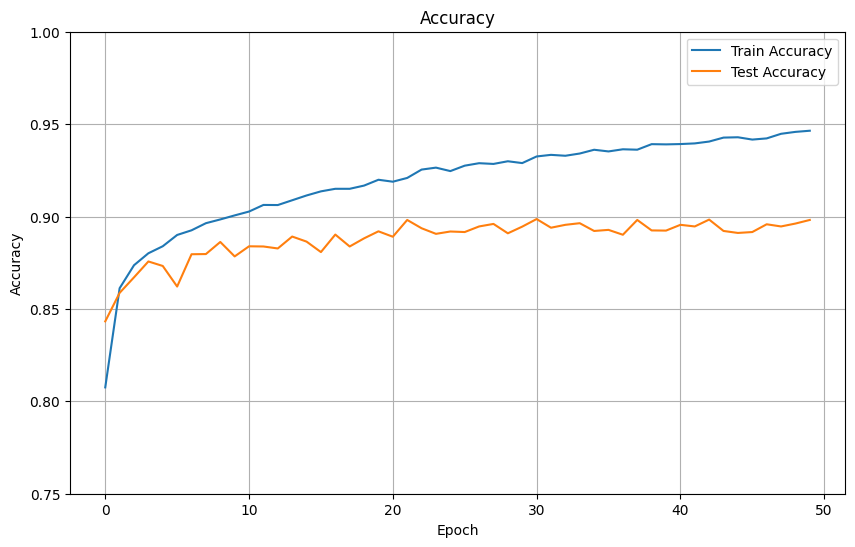

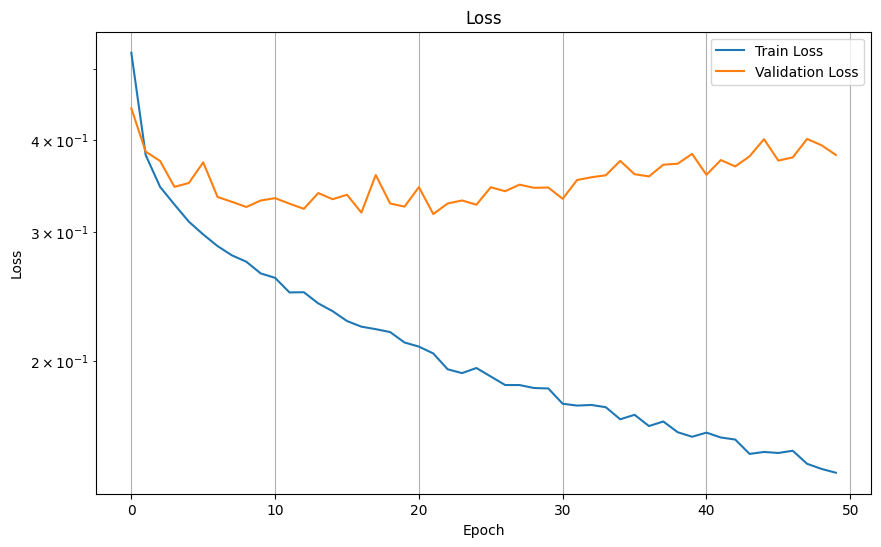

In [73]:
plot_accuracy(train_accuracy, test_accuracy)
plot_loss(train_loss, test_loss)

В данной задаче усилили эффект переобучения, графики лосса и аккураси расползлись. Данный эффект получилось реализовать значительным  понижением значения Dropout, который собственно и отвечает за фиксинг переобучение.
В следующей задаче пофиксим этот момент и улучшим нашу сеть.

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

In [120]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, 512),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(128, num_classes),
            nn.BatchNorm1d(num_classes),
            nn.ReLU(),
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

In [121]:
model = FixedNeuralNetwork().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.005)
loss_func = nn.CrossEntropyLoss()

In [122]:
n_epochs = 50

train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []

In [123]:
for epoch in range(n_epochs):

    model.train()

    epoch_train_loss, epoch_train_accuracy =  train_func(model, train_loader, optimizer, loss_func)
    train_loss.append(sum(epoch_train_loss) / len(epoch_train_loss))
    train_accuracy.append(sum(epoch_train_accuracy) / len(epoch_train_accuracy))

    model.eval()

    epoch_test_loss, epoch_test_accuracy = test_func(model, test_loader, loss_func)
    test_loss.append(sum(epoch_test_loss) / len(epoch_test_loss))
    test_accuracy.append(sum(epoch_test_accuracy) / len(epoch_test_accuracy))

    logging(epoch, n_epochs, train_loss, train_accuracy, test_loss, test_accuracy)

Epoch [1/50], Train Loss: 1.5179, Train Accuracy: 0.5546, Test Loss: 1.0185, Test Accuracy: 0.7679
Epoch [2/50], Train Loss: 1.1012, Train Accuracy: 0.7245, Test Loss: 0.8215, Test Accuracy: 0.7949
Epoch [3/50], Train Loss: 0.9485, Train Accuracy: 0.7633, Test Loss: 0.7139, Test Accuracy: 0.8174
Epoch [4/50], Train Loss: 0.8446, Train Accuracy: 0.7871, Test Loss: 0.6419, Test Accuracy: 0.8232
Epoch [5/50], Train Loss: 0.7729, Train Accuracy: 0.8047, Test Loss: 0.5910, Test Accuracy: 0.8344
Epoch [6/50], Train Loss: 0.7205, Train Accuracy: 0.8148, Test Loss: 0.5490, Test Accuracy: 0.8356
Epoch [7/50], Train Loss: 0.6788, Train Accuracy: 0.8220, Test Loss: 0.5225, Test Accuracy: 0.8446
Epoch [8/50], Train Loss: 0.6463, Train Accuracy: 0.8265, Test Loss: 0.5014, Test Accuracy: 0.8490
Epoch [9/50], Train Loss: 0.6169, Train Accuracy: 0.8327, Test Loss: 0.4834, Test Accuracy: 0.8499
Epoch [10/50], Train Loss: 0.5879, Train Accuracy: 0.8394, Test Loss: 0.4642, Test Accuracy: 0.8544
Epoch [11

In [126]:
print('Train Loss:', train_loss[-1])
print('Test Loss:', test_loss[-1])
print()
print('Train Accuracy:', train_accuracy[-1])
print('Test Accuracy:', test_accuracy[-1])

Train Loss: 0.3235113634737824
Test Loss: 0.3192780915647745

Train Accuracy: 0.8971715085287847
Test Accuracy: 0.89052734375


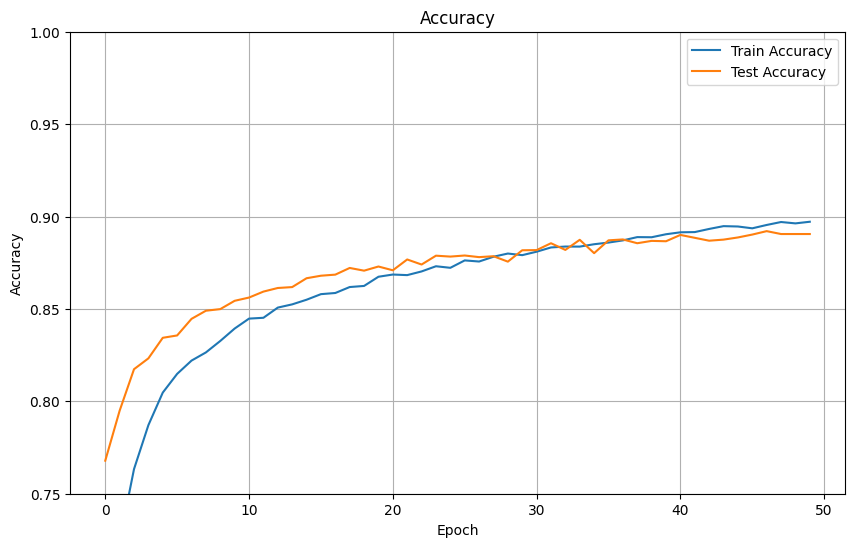

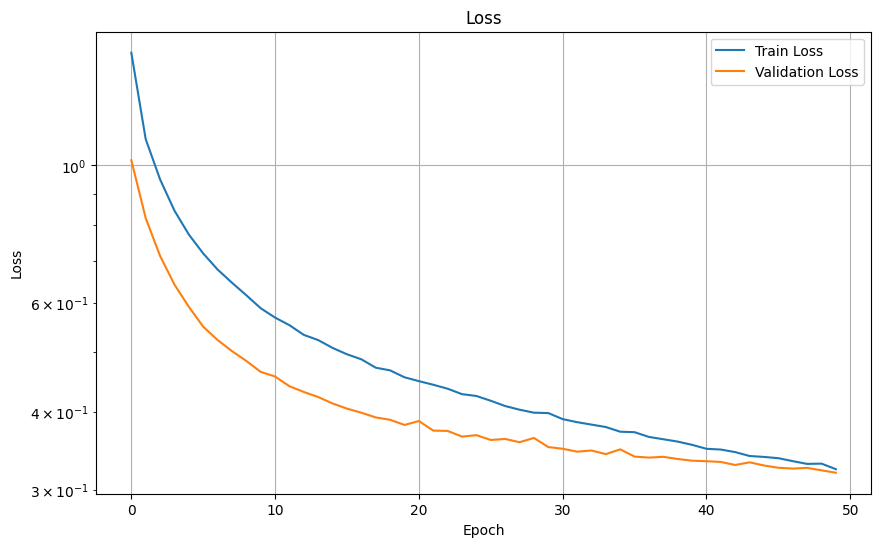

In [127]:
plot_accuracy(train_accuracy, test_accuracy)
plot_loss(train_loss, test_loss)

### Conclusions:
_Write down small report with your conclusions and your ideas._

**Задача 1. Необходимо обучите сеть с точностью теста >= 0,885 используя только линейные слои.**

Задача выполнена, получилось реализовать довольно простую архитектуру нейронной сети TinyNeuralNetwork с линейным слоем и дропаутом. Сеть обучалась с использованием оптимизатора Adam и CrossEntropyLoss в качестве функции потерь, рейт был выбран равным lr=0.001. После обучения сети в течение 20 эпох получил точность обучения 0.889 на тесте, что соответствует поставленной задачи.

**Задача 2. Необходимо реализовать и обучить нейронную сеть переобучением.**

В первой задачу уже видны были элементы переобучения и далее развил их в данном пункте. Архитектура сети представленна реализацией OverfittingNeuralNetwork. Чтобы спровоцировать дальнейшее переобучение, я немного усложнил сеть и понизил Dropout(0.1) с коээфициентом 0.1. Также увеличил количество эпох обучения и lr=0.002. Помимо графиков, можно численно увидеть, как разошлась точность обучения на трейне и тесте:
Train Accuracy: 0.9464
Test Accuracy: 0.8981

**Задача 3: Необходимо реализовать и обучить нейронную сеть, которая исправляет переобучение.**
Реализация архитектуры представлена в FixedNeuralNetwork. Я усложнил сеть, добавив дополнительные слои, а также Dropout с повышением коэффициента до 0.5 и нормализацию BatchNorm1d.
Эксперимент проводил на 50 эпохах, в качестве оптимизатора использовал SGD.
Как видно на графиках, переобучение не происходит, также это видно по численным значениям, где видно, что разница в точности минимальна:
Train Accuracy: 0.8971
Test Accuracy: 0.8905

**Вывод**
Можно сделать вывод, что предпринятые методы в виде реализации различных архитектур, подборки гиперпараметров и дополнительных методов регуляризации, таких как пакетная нормализация и дропаут помогают с проблемой переобучения.